In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 18 16:29:02 PDT 2019


# Table of SAM DALYs and delta SAM DALYs by scenario and by location

In [2]:
%cd /share/costeffectiveness/results/vivarium_conic_sam_comparison

/ihme/costeffectiveness/results/vivarium_conic_sam_comparison


In [3]:
import glob
# sorted(glob.glob('*/*/output.hdf'))

In [4]:
location_list = ['India', 'Bangladesh', 'Pakistan', 'Tanzania', 'Malawi', 'Mali']
fname = {}
for loc in location_list:
    fname[loc] = sorted(glob.glob(f'vivarium_conic_sam_comparison_{loc}/*/output.hdf'))[-1]
fname

{'India': 'vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf',
 'Bangladesh': 'vivarium_conic_sam_comparison_Bangladesh/2019_09_12_16_06_24/output.hdf',
 'Pakistan': 'vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf',
 'Tanzania': 'vivarium_conic_sam_comparison_Tanzania/2019_09_12_14_36_50/output.hdf',
 'Malawi': 'vivarium_conic_sam_comparison_Malawi/2019_09_12_14_36_29/output.hdf',
 'Mali': 'vivarium_conic_sam_comparison_Mali/2019_09_12_14_36_37/output.hdf'}

In [5]:
df = {}
for loc in location_list:
    df[loc] = pd.read_hdf(fname[loc])
    print(loc, len(df[loc]))

India 4000
Bangladesh 4000
Pakistan 4000
Tanzania 4000
Malawi 4000
Mali 4000


In [6]:
for loc in location_list:
    del df[loc]['random_seed']

In [7]:
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]

for loc in location_list:
    g = df[loc].reset_index().groupby(scenarios + ['input_draw_number'])
    print(f'{loc} has {len(g.groups)} groups, with {len(df[loc])/len(g.groups):.2f} reps per group')
    df[loc] = g.sum()


India has 400 groups, with 10.00 reps per group
Bangladesh has 400 groups, with 10.00 reps per group
Pakistan has 400 groups, with 10.00 reps per group
Tanzania has 400 groups, with 10.00 reps per group
Malawi has 400 groups, with 10.00 reps per group
Mali has 400 groups, with 10.00 reps per group


In [8]:
def scenario_map_generator():
    baseline = (0,0,0)
    bep = (.8, 0, 0)
    sqlns = (0, .8, 0)
    tfsam = (0, 0, .8)
    scenario_map = dict(baseline=baseline, bep=bep, sqlns=sqlns, tfsam=tfsam)

    return scenario_map
scenario_map = scenario_map_generator()

In [9]:
cause_list = ('lower_respiratory_infections diarrheal_diseases measles '
              + 'protein_energy_malnutrition ' +'other_causes '
              + 'neonatal_preterm_birth neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma '
              + 'hemolytic_disease_and_other_neonatal_jaundice '
              + 'neonatal_sepsis_and_other_neonatal_infections'
             ).split()

In [10]:
def dalys_per_100k(df, scenario):
    
    scenario = scenario_map[scenario]
    
    # sam person years
    py = df.loc[scenario, 'person_time_in_child_stunting_cat1']
    dalys = pd.Series(0, index=py.index)
    for outcome in ['ylls', 'ylds']:
        for cause in cause_list:
            if outcome == 'ylds' and cause == 'other_causes':
                continue # YLDs for other causes is not tracked
            key = f'{outcome}_due_to_{cause}_in_child_stunting_cat1'

            dalys += df.loc[scenario, key]
    
    return 100_000 * dalys / py
dalys_per_100k(df[loc], 'baseline').describe()

count    1.000000e+02
mean     6.672022e+05
std      9.713266e+04
min      4.410838e+05
25%      6.056786e+05
50%      6.528794e+05
75%      7.259078e+05
max      1.059871e+06
dtype: float64

In [11]:
import pymc as pm

In [12]:
def my_formatted_output_pct(s):
    mu = f'{s.mean():.2f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{lb:.2f}'
    ub = f'{ub:.2f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu, 'lb':lb, 'ub':ub}

In [13]:
def my_formatted_output_dalys(s):
    mu = f'{np.round(s.mean(), -3):.0f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{np.round(lb, -3):.0f}'
    ub = f'{np.round(ub, -3):.0f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu}#, 'lb':lb, 'ub':ub}
my_formatted_output_dalys(dalys_per_100k(df[loc], 'baseline'))

{'mean': '667000'}

In [14]:
results = {}

for loc in location_list:
    val_0 = dalys_per_100k(df[loc], 'baseline')
    for scenario in ['baseline', 'bep', 'sqlns', 'tfsam']:
        val_1 = dalys_per_100k(df[loc], scenario)
        results[loc, scenario, 'dalys'] = my_formatted_output_dalys(val_1)
        if scenario != 'baseline':
            results[loc, scenario, 'dalys_averted'] = my_formatted_output_dalys(val_0-val_1)
            results[loc, scenario, 'pct_averted'] = my_formatted_output_pct(100*(val_0-val_1)/val_0)
results = pd.DataFrame(results)        

In [15]:
results = results.T.unstack().unstack().dropna(axis=1, how='all')

In [16]:
# col_to_sort = (0, 'pct', 'baseline')
col_to_sort = ('mean', 'dalys', 'baseline')
results.sort_values(col_to_sort, ascending=False)

mean                                                      \
              dalys                         dalys_averted                 
           baseline     bep   sqlns   tfsam           bep  sqlns  tfsam   
Mali         667000  622000  657000  615000         45000  10000  53000   
Tanzania     625000  568000  615000  563000         57000  10000  62000   
Malawi       544000  500000  535000  497000         44000  10000  47000   
Pakistan     303000  276000  298000  280000         26000   5000  23000   
India        213000  197000  211000  197000         17000   3000  16000   
Bangladesh   168000  155000  166000  157000         14000   2000  12000   

                                            lb                      ub        \
           pct_averted             pct_averted             pct_averted         
                   bep sqlns tfsam         bep sqlns tfsam         bep sqlns   
Mali              6.70  1.49  7.81        4.81  0.64  5.54        8.48  2.36   
Tanzania          9.10  1.67  9.81        5.92  0.26  6.58       12.02  3.07   
Malawi            8.09  1.80  8.61        5.26  0.07  5.65       11.52  3.59   
Pakistan          8.64  1.60  7.59        5.54  0.65  5.23       11.26  2.71   
India             7.76  1.24  7.58        5.41  0.35  5.76       10.10  2.31   
Bangladesh        7.96  1.47  6.88        4.72  0.39  3.48       11.53  2.77   

                   
                   
            tfsam  
Mali        10.16  
Tanzania    13.05  
Malawi      13.26  
Pakistan    10.53  
India       10.25  
Bangladesh  10.03

In [17]:
results.loc[location_list]

mean                                                      \
              dalys                         dalys_averted                 
           baseline     bep   sqlns   tfsam           bep  sqlns  tfsam   
India        213000  197000  211000  197000         17000   3000  16000   
Bangladesh   168000  155000  166000  157000         14000   2000  12000   
Pakistan     303000  276000  298000  280000         26000   5000  23000   
Tanzania     625000  568000  615000  563000         57000  10000  62000   
Malawi       544000  500000  535000  497000         44000  10000  47000   
Mali         667000  622000  657000  615000         45000  10000  53000   

                                            lb                      ub        \
           pct_averted             pct_averted             pct_averted         
                   bep sqlns tfsam         bep sqlns tfsam         bep sqlns   
India             7.76  1.24  7.58        5.41  0.35  5.76       10.10  2.31   
Bangladesh        7.96  1.47  6.88        4.72  0.39  3.48       11.53  2.77   
Pakistan          8.64  1.60  7.59        5.54  0.65  5.23       11.26  2.71   
Tanzania          9.10  1.67  9.81        5.92  0.26  6.58       12.02  3.07   
Malawi            8.09  1.80  8.61        5.26  0.07  5.65       11.52  3.59   
Mali              6.70  1.49  7.81        4.81  0.64  5.54        8.48  2.36   

                   
                   
            tfsam  
India       10.25  
Bangladesh  10.03  
Pakistan    10.53  
Tanzania    13.05  
Malawi      13.26  
Mali        10.16

# Figures for presentation

In [18]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

def set_plot_size():
    from IPython.core.pylabtools import figsize
    figsize(11, 5.5)
set_plot_size()

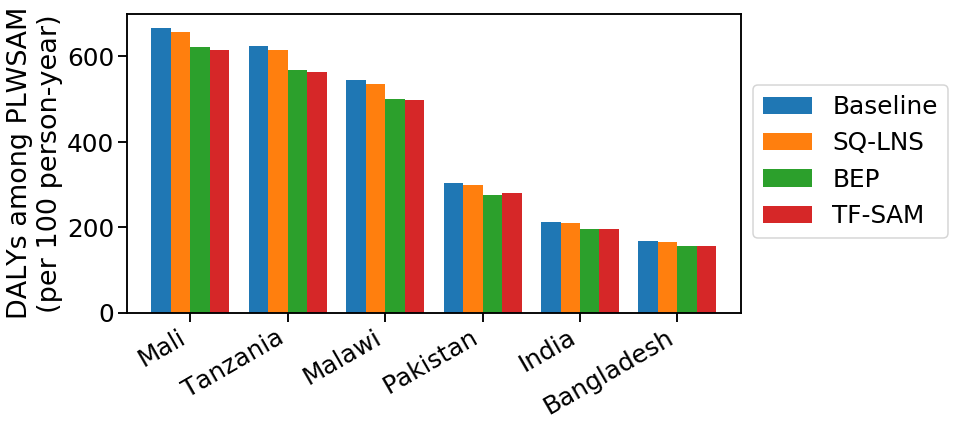

In [19]:
def my_plot(cols_to_blank=[]):
    t = (results.loc[location_list, ('mean', 'dalys')].astype(float)/1_000)\
        .filter(['baseline', 'sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['Baseline', 'SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('Baseline', ascending=False)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs among PLWSAM\n(per 100 person-year)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

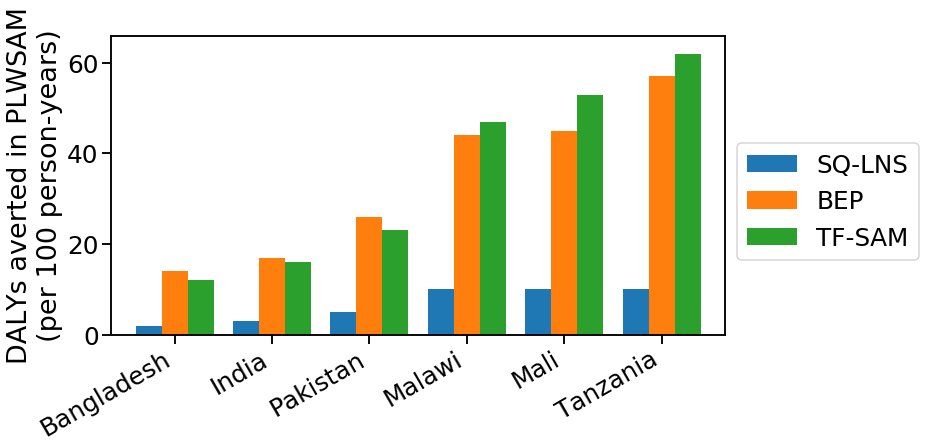

In [20]:
def my_plot(cols_to_blank=[]):
    t = (results.loc[location_list, ('mean', 'dalys_averted')].astype(float)/1_000)\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
    plt.axis(ymax=66)
    plt.ylabel('DALYs averted in PLWSAM\n(per 100 person-years)')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

In [21]:
results.loc[location_list, ('mean', 'dalys_averted')]
# results.loc[location_list, ('mean', 'pct_averted')]

,bep,sqlns,tfsam
India,17000,3000,16000
Bangladesh,14000,2000,12000
Pakistan,26000,5000,23000
Tanzania,57000,10000,62000
Malawi,44000,10000,47000
Mali,45000,10000,53000


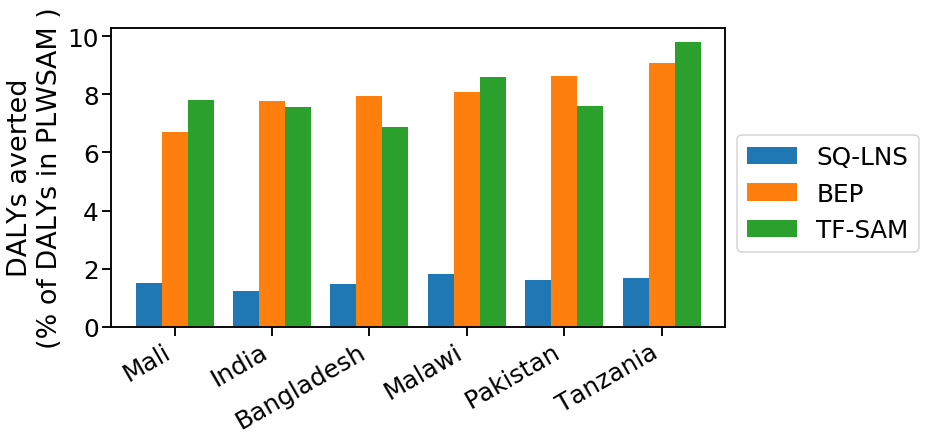

In [22]:
def my_plot(cols_to_blank=[]):
    t = (results.loc[location_list, ('mean', 'pct_averted')].astype(float))\
        .filter(['sqlns', 'bep', 'tfsam'])
    
    t = t.sort_values('bep', ascending=True)
    t.loc[:, cols_to_blank] = 0

    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))
#     plt.axis(ymax=66)
    plt.ylabel('DALYs averted\n(% of DALYs in PLWSAM )')
    plt.xticks(rotation=30, ha='right')
my_plot(cols_to_blank=[])

In [23]:
results.loc[location_list, ('mean', 'pct_averted')]

,bep,sqlns,tfsam
India,7.76,1.24,7.58
Bangladesh,7.96,1.47,6.88
Pakistan,8.64,1.60,7.59
Tanzania,9.10,1.67,9.81
Malawi,8.09,1.80,8.61
Mali,6.70,1.49,7.81


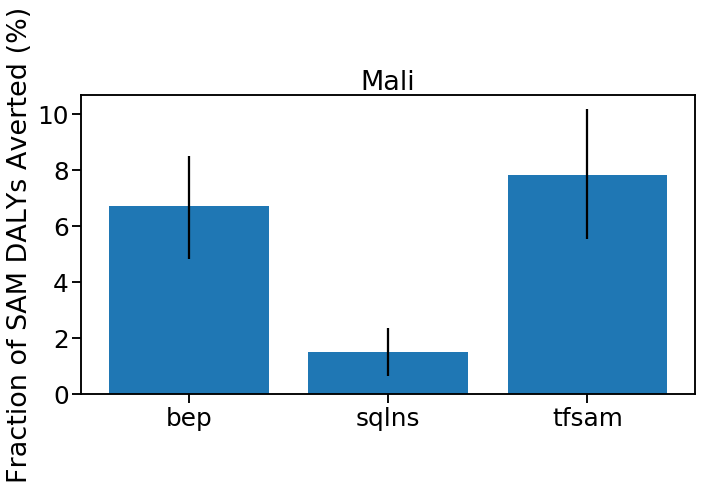

In [24]:
t = results.loc[loc, ('mean', 'pct_averted')]
plt.bar(t.index, t.astype(float).values, bottom=0, yerr=(
   t.astype(float).values-results.loc[loc, ('lb', 'pct_averted')].astype(float),
   results.loc[loc, ('ub', 'pct_averted')].astype(float)-t.astype(float).values,))

plt.ylabel('Fraction of SAM DALYs Averted (%)')
plt.title(loc);

In [25]:
my_formatted_output_pct(dalys_per_100k(df[loc], 'sqlns') - dalys_per_100k(df[loc], 'bep'))

{'mean': '34970.21', 'lb': '20611.73', 'ub': '52109.09'}

In [26]:
my_formatted_output_pct(dalys_per_100k(df[loc], 'tfsam') - dalys_per_100k(df[loc], 'bep'))

{'mean': '-7543.04', 'lb': '-23735.39', 'ub': '4174.16'}

t = sqlns - bep =  {'mean': '13947.58', 'lb': '7604.30', 'ub': '18310.46'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '397.33', 'lb': '-4240.10', 'ub': '4643.19'} Pr[t>0] =  0.58 (n = 100)


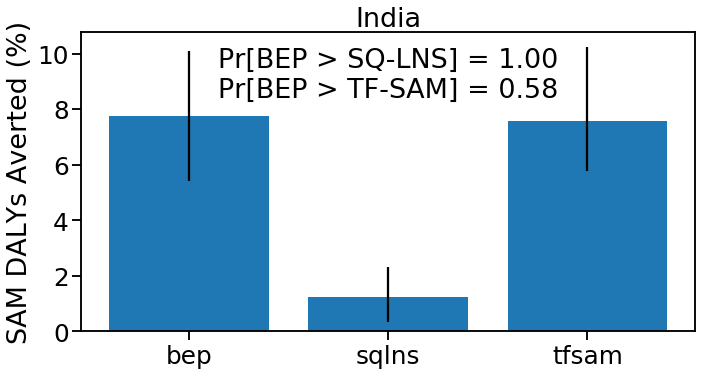

In [27]:
def my_compare(loc):
    t = results.loc[loc, ('mean', 'pct_averted')]
    plt.bar(t.index, t.astype(float).values, bottom=0, yerr=(
       t.astype(float).values-results.loc[loc, ('lb', 'pct_averted')].astype(float),
       results.loc[loc, ('ub', 'pct_averted')].astype(float)-t.astype(float).values,))

    plt.ylabel('SAM DALYs Averted (%)')
    plt.title(loc)
    
    t = dalys_per_100k(df[loc], 'sqlns') - dalys_per_100k(df[loc], 'bep')
    print('t = sqlns - bep = ', my_formatted_output_pct(t), 'Pr[t>0] = ', np.mean(t > 0), f'(n = {len(t)})')
    plt.text(.5, .95, f'Pr[BEP > SQ-LNS] = {np.mean(t > 0):.2f}',
             transform=plt.gca().transAxes, ha='center', va='top')

    t = dalys_per_100k(df[loc], 'tfsam') - dalys_per_100k(df[loc], 'bep')
    print('t = tfsam - bep = ', my_formatted_output_pct(t), 'Pr[t>0] = ', np.mean(t > 0), f'(n = {len(t)})')
    plt.axis(ymin=0)

    plt.text(.5, .95, f'\nPr[BEP > TF-SAM] = {np.mean(t > 0):.2f}',
             transform=plt.gca().transAxes, ha='center', va='top')

my_compare(loc='India')

t = sqlns - bep =  {'mean': '11051.75', 'lb': '4481.09', 'ub': '20686.60'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '1880.20', 'lb': '-4863.49', 'ub': '7203.86'} Pr[t>0] =  0.71 (n = 100)


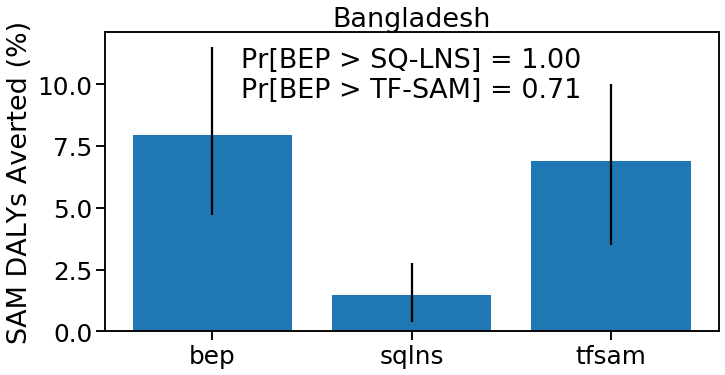

In [28]:
my_compare(loc='Bangladesh')

t = sqlns - bep =  {'mean': '21387.36', 'lb': '11388.39', 'ub': '28847.66'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '3157.22', 'lb': '-4539.53', 'ub': '13566.08'} Pr[t>0] =  0.75 (n = 100)


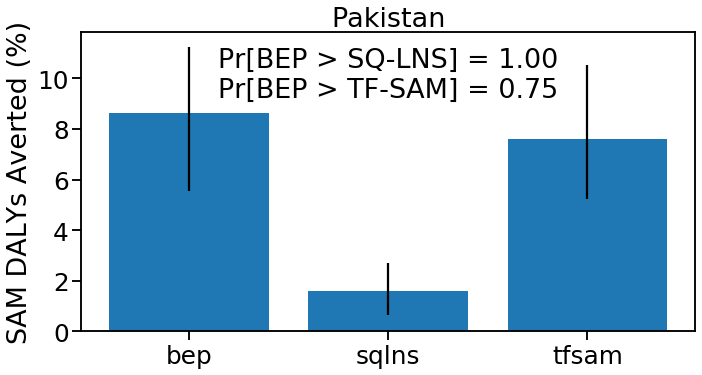

In [29]:
my_compare(loc='Pakistan')

t = sqlns - bep =  {'mean': '34396.61', 'lb': '16807.24', 'ub': '55794.08'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '-2866.68', 'lb': '-20496.21', 'ub': '20288.73'} Pr[t>0] =  0.4 (n = 100)


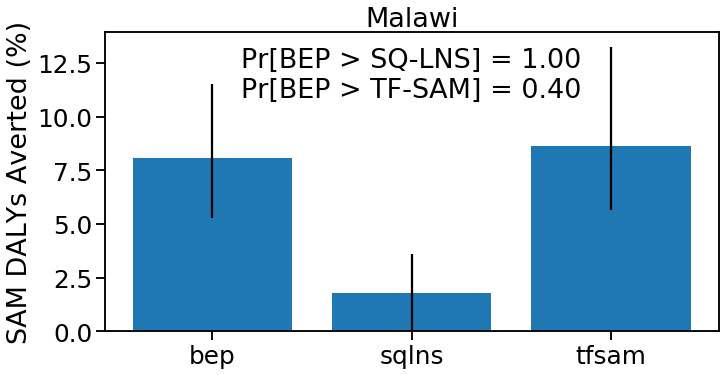

In [30]:
my_compare(loc='Malawi')

t = sqlns - bep =  {'mean': '46907.50', 'lb': '25780.44', 'ub': '79849.60'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '-4554.85', 'lb': '-23707.41', 'ub': '19004.40'} Pr[t>0] =  0.36 (n = 100)


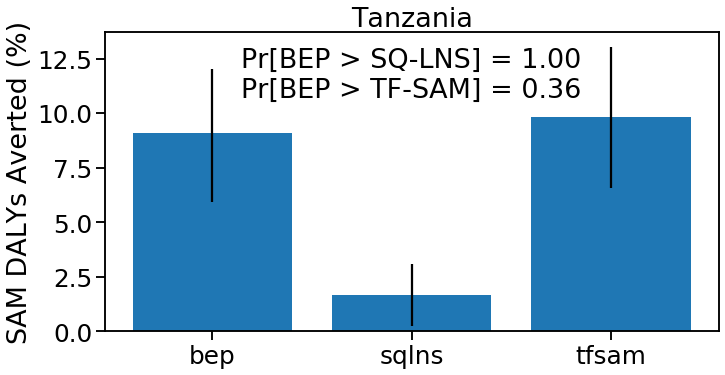

In [31]:
my_compare(loc='Tanzania')

t = sqlns - bep =  {'mean': '34970.21', 'lb': '20611.73', 'ub': '52109.09'} Pr[t>0] =  1.0 (n = 100)
t = tfsam - bep =  {'mean': '-7543.04', 'lb': '-23735.39', 'ub': '4174.16'} Pr[t>0] =  0.14 (n = 100)


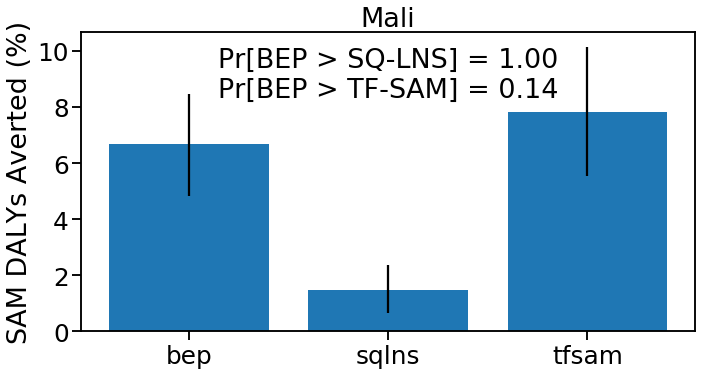

In [32]:
my_compare(loc='Mali')